In [26]:
%pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [27]:
%matplotlib inline

In [28]:
import pandas as pd

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [29]:
data = pd.read_csv("~/datamodified.csv")
data.head()

,expression,gene,strain,time,Bio
0,0.036195,idr2,ura3,0,A
1,0.010887,idr2,ura3,5,A
2,0.005983,idr2,ura3,20,A
3,0.003750,idr2,ura3,60,A
4,0.042606,idr2,ura3,0,B


In [30]:
data['dtror'] = data.strain == 'tror'
data['didr1'] = data.strain == 'idr1'
data['didr2'] = data.strain == 'idr2'
data['dsirr'] = data.strain == 'sirr'

data.head()

,expression,gene,strain,time,Bio,dtror,didr1,didr2,dsirr
0,0.036195,idr2,ura3,0,A,False,False,False,False
1,0.010887,idr2,ura3,5,A,False,False,False,False
2,0.005983,idr2,ura3,20,A,False,False,False,False
3,0.003750,idr2,ura3,60,A,False,False,False,False
4,0.042606,idr2,ura3,0,B,False,False,False,False


In [31]:
sum(data.gene=='tror')

36

In [32]:
data['normexpression'] = np.log2(data.expression)
data['normexpression'] = (data['normexpression']-data['normexpression'].mean())/data['normexpression'].std()

data.head()

,expression,gene,strain,time,Bio,dtror,didr1,didr2,dsirr,normexpression
0,0.036195,idr2,ura3,0,A,False,False,False,False,0.575864
1,0.010887,idr2,ura3,5,A,False,False,False,False,0.037007
2,0.005983,idr2,ura3,20,A,False,False,False,False,-0.231570
3,0.003750,idr2,ura3,60,A,False,False,False,False,-0.441094
4,0.042606,idr2,ura3,0,B,False,False,False,False,0.649012


In [33]:
g = data.groupby(['gene', 'time'])

def scale(x):
    x.normexpression = (x.normexpression - x.normexpression.mean())/x.normexpression.std()
    return x

data = g.apply(scale)

In [34]:
def plotGene(g,time=None):
    temp = data[data.gene==g]
    
    if not time is None:
        temp = temp[temp.time==time]
    
    for i,d in enumerate(['dtror', 'didr1', 'didr2', 'dsirr']):
        if d[1:] == g:
            continue
        
        plt.subplot(1,4,i+1)
        plt.title(d)
        plt.boxplot([temp[temp[d]].normexpression, temp[~temp[d]].normexpression], labels=[d,'dura3'])
        
        
    plt.tight_layout()

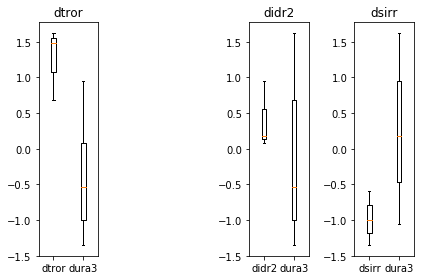

In [35]:
plotGene('idr1',0)

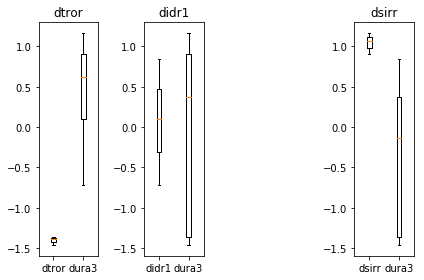

In [36]:
plotGene('idr2',0)

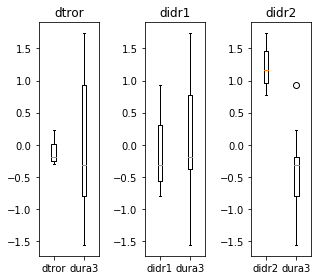

In [37]:
plotGene('sirr',0)

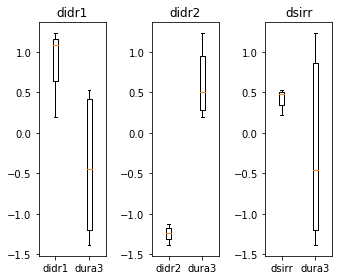

In [38]:
plotGene('tror',0)

In [39]:
# eq = 'expression ~ C(condition, Sum)*C(dsirr, Sum)' + \
#         '+ C(condition, Sum)*C(dtror, Sum) + ' + \
#         '+ C(condition, Sum)*C(didr1, Sum) + ' + \
#         '+ C(condition, Sum)*C(didr2, Sum) + '

def eq(s):
    e = 'normexpression ~'
    
    for d in ['dtror', 'didr1', 'didr2', 'dsirr']:
        if d[1:] == s:
            continue
        e += 'C(%s, Sum) + '%d
    return e[:-2]

# eq = 'normexpression ~ C(dsirr, Sum)' + \
#         '+ C(dtror, Sum) + ' + \
#         '+ C(didr1, Sum) + ' + \
#         '+ C(didr2, Sum)'

lm_idr1 = ols(eq('idr1'), data=data[(data.gene=='idr1') & (data.time==0)]).fit()
lm_idr2 = ols(eq('idr2'), data=data[(data.gene=='idr2') & (data.time==0)]).fit()
lm_sirr = ols(eq('sirr'), data=data[(data.gene=='sirr') & (data.time==0)]).fit()
lm_tror = ols(eq('tror'), data=data[(data.gene=='tror') & (data.time==0)]).fit()

In [40]:
sm.stats.anova_lm(lm_idr1, typ=2)

,sum_sq,df,F,PR(>F)
"C(dtror, Sum)",5.671535,1.0,30.886299,0.000536
"C(didr2, Sum)",1.772915,1.0,9.655021,0.014506
"C(dsirr, Sum)",0.130234,1.0,0.709236,0.424157
Residual,1.469010,8.0,NaN,NaN


In [41]:
lm_idr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         normexpression   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     17.30
Date:                Mon, 15 May 2017   Prob (F-statistic):           0.000740
Time:                        22:19:10   Log-Likelihood:                -4.4254
No. Observations:                  12   AIC:                             16.85
Df Residuals:                       8   BIC:                             18.79
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  0.6843      0.247      2.766      0.024         0.114     1.255
C(dtror, Sum)[S.False]    -0.9722      0.175     -5.558      0.001        -1.376    -0.569
C(didr2, Sum)[S.False]    -0.5436      0.175     -3.107      0.015        -0.947    -0.140
C(dsirr, Sum)[S.False]     0.1473      0.175      0.842      0.424        -0.256     0.551
==============================================================================
Omnibus:                        2.129   Durbin-Watson:                   2.631
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                0.915
Skew:                          -0.100   Prob(JB):                        0.633
Kurtosis:                       1.663   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
sm.stats.anova_lm(lm_idr2, typ=2)

,sum_sq,df,F,PR(>F)
"C(dtror, Sum)",4.258075,1.0,21.892869,0.001584
"C(didr1, Sum)",0.062492,1.0,0.321305,0.586372
"C(dsirr, Sum)",0.875896,1.0,4.503413,0.066605
Residual,1.555968,8.0,NaN,NaN


In [43]:
lm_idr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         normexpression   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     16.19
Date:                Mon, 15 May 2017   Prob (F-statistic):           0.000928
Time:                        22:19:17   Log-Likelihood:                -4.7704
No. Observations:                  12   AIC:                             17.54
Df Residuals:                       8   BIC:                             19.48
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                 -0.2812      0.255     -1.104      0.302        -0.868     0.306
C(dtror, Sum)[S.False]     0.8424      0.180      4.679      0.002         0.427     1.258
C(didr1, Sum)[S.False]     0.1021      0.180      0.567      0.586        -0.313     0.517
C(dsirr, Sum)[S.False]    -0.3821      0.180     -2.122      0.067        -0.797     0.033
==============================================================================
Omnibus:                        2.559   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                0.440
Skew:                          -0.152   Prob(JB):                        0.803
Kurtosis:                       3.887   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sm.stats.anova_lm(lm_sirr, typ=2)

,sum_sq,df,F,PR(>F)
"C(dtror, Sum)",1.457169,1.0,3.893876,0.083915
"C(didr1, Sum)",1.532508,1.0,4.095201,0.077617
"C(didr2, Sum)",7.936084,1.0,21.206969,0.001744
Residual,2.993765,8.0,NaN,NaN


In [45]:
sm.stats.anova_lm(lm_tror, typ=2)

,sum_sq,df,F,PR(>F)
"C(didr1, Sum)",2.811780,1.0,23.388621,0.002892
"C(didr2, Sum)",6.224053,1.0,51.772194,0.000365
"C(dsirr, Sum)",0.669073,1.0,5.565407,0.056352
Residual,0.721320,6.0,NaN,NaN


In [46]:
lm_idr1.params

Intercept                 0.684250
C(dtror, Sum)[S.False]   -0.972243
C(didr2, Sum)[S.False]   -0.543586
C(dsirr, Sum)[S.False]    0.147329
dtype: float64

In [47]:
lm_idr2.params

Intercept                -0.281202
C(dtror, Sum)[S.False]    0.842425
C(didr1, Sum)[S.False]    0.102056
C(dsirr, Sum)[S.False]   -0.382077
dtype: float64

In [48]:
lm_sirr.params

Intercept                 1.074139
C(dtror, Sum)[S.False]   -0.492810
C(didr1, Sum)[S.False]   -0.505389
C(didr2, Sum)[S.False]   -1.150079
dtype: float64

In [49]:
lm_sirr.conf_int().loc["C(%s, Sum)[S.False]"%d,:]

NameError: name 'd' is not defined

In [50]:
lm_tror.params

Intercept                -2.081668e-17
C(didr1, Sum)[S.False]   -4.192091e-01
C(didr2, Sum)[S.False]    6.237013e-01
C(dsirr, Sum)[S.False]   -2.044922e-01
dtype: float64

In [51]:
lm_tror.pvalues

Intercept                 1.000000
C(didr1, Sum)[S.False]    0.002892
C(didr2, Sum)[S.False]    0.000365
C(dsirr, Sum)[S.False]    0.056352
dtype: float64

In [52]:
coeff = []
sig = []
conf = []

for t in [0, 5, 20, 60]:
    
    lm_idr1 = ols(eq('idr1'), data=data[(data.gene=='idr1') & (data.time==t)]).fit()
    lm_idr2 = ols(eq('idr2'), data=data[(data.gene=='idr2') & (data.time==t)]).fit()
    lm_sirr = ols(eq('sirr'), data=data[(data.gene=='sirr') & (data.time==t)]).fit()
    lm_tror = ols(eq('tror'), data=data[(data.gene=='tror') & (data.time==t)]).fit()
    
    coeff.append([])
    sig.append([])
    conf.append([])
    for lm in [lm_idr1, lm_idr2, lm_sirr, lm_tror]:
        coeff[-1].append([])
        sig[-1].append([])
        conf[-1].append([])
        
        for d in ['didr1', 'didr2', 'dsirr', 'dtror']:
            try:
                coeff[-1][-1].append(lm.params["C(%s, Sum)[S.False]"%d])
                sig[-1][-1].append(lm.pvalues["C(%s, Sum)[S.False]"%d])
                conf[-1][-1].append(lm.conf_int().loc["C(%s, Sum)[S.False]"%d,:])
            except:
                coeff[-1][-1].append(np.nan)
                sig[-1][-1].append(np.nan)
                conf[-1][-1].append([np.nan]*2)

coeff = np.array(coeff)
sig = np.array(sig)
conf = np.array(conf)

In [53]:
conf[0,0,1:,0]

array([-0.94700089, -0.2560862 , -1.37565746])

In [54]:
conf[0,0,1:,0]

array([-0.94700089, -0.2560862 , -1.37565746])

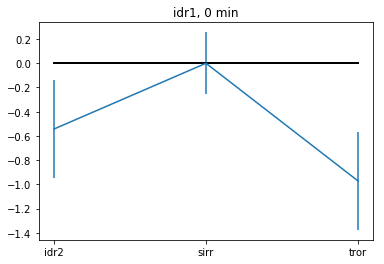

In [65]:
i = 0
j = 0

ind = range(4)
ind.remove(i)

plt.errorbar(range(3), coeff[0,0,ind], yerr=coeff[0,0,ind]-conf[0,0,ind,0])
plt.plot([0,2], [0,0], lw=2, c='k')
plt.xticks(range(3), [order[z] for z in ind])
plt.title('%s, %s min' % (order[i], [0,5,20,60][j]))

In [66]:
order = ['idr1', 'idr2', 'sirr', 'tror']

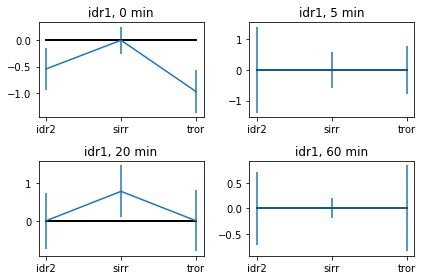

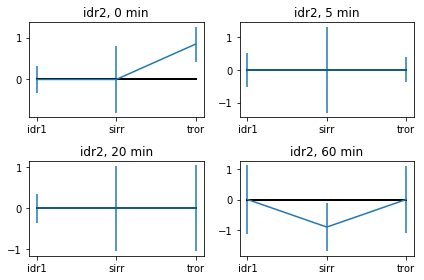

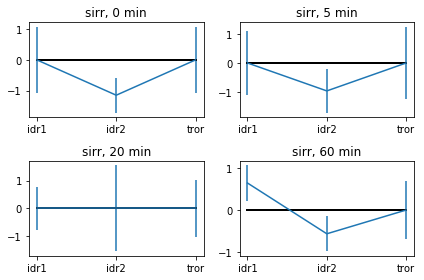

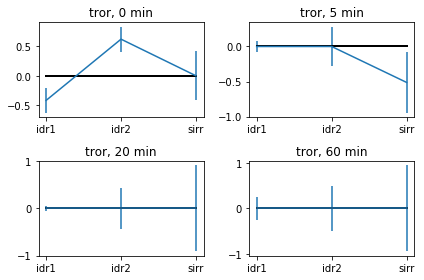

In [67]:
##Preliminary visualization of node activities.
for i in range(4):
    plt.figure()
    
    for j in range(4):
        ind = range(4)
        ind.remove(i)
        
        plt.subplot(2,2,j+1)
        
        plt.errorbar(range(3), coeff[j,i,ind], yerr=coeff[j,i,ind]-conf[j,i,ind,0])
        plt.plot([0,2], [0,0], lw=2, c='k')
        plt.xticks(range(3), [order[z] for z in ind])
        plt.title('%s, %s min' % (order[i], [0,5,20,60][j]))
        
    plt.tight_layout()
    plt.savefig('%s.pdf'% (order[i]),bbox_inches='tight')

In [68]:
#final networks used to generate topologies for paper Figure 4. 
net0 = pd.DataFrame(coeff[0,:,:], columns=order, index=order)
net0.values[sig[0,:,:] > 5e-2] = 0
net0.to_csv("net0.csv")

net0

/Users/as305/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


,idr1,idr2,sirr,tror
idr1,NaN,-0.543586,0.0,-0.972243
idr2,0.000000,NaN,0.0,0.842425
sirr,0.000000,-1.150079,NaN,0.000000
tror,-0.419209,0.623701,0.0,NaN


In [69]:
net5 = pd.DataFrame(coeff[1,:,:], columns=order, index=order)
net5.values[sig[1,:,:] > 5e-2] = 0
net5.to_csv("net5.csv")
net5

/Users/as305/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


,idr1,idr2,sirr,tror
idr1,NaN,0.00000,0.000000,0.0
idr2,0.0,NaN,0.000000,0.0
sirr,0.0,-0.96638,NaN,0.0
tror,0.0,0.00000,-0.512084,NaN


In [60]:
net20 = pd.DataFrame(coeff[2,:,:], columns=order, index=order)
net20.values[sig[2,:,:] > 5e-2] = 0
net20.to_csv("net20.csv")
net20

/Users/as305/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


,idr1,idr2,sirr,tror
idr1,NaN,0.0,0.789413,0.0
idr2,0.0,NaN,0.000000,0.0
sirr,0.0,0.0,NaN,0.0
tror,0.0,0.0,0.000000,NaN


In [61]:
net60 = pd.DataFrame(coeff[3,:,:], columns=order, index=order)
net60.values[sig[3,:,:] > 5e-2] = 0

net60.to_csv("net60.csv")
net60

/Users/as305/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


,idr1,idr2,sirr,tror
idr1,NaN,0.000000,0.000000,0.0
idr2,0.000000,NaN,-0.906313,0.0
sirr,0.639498,-0.562464,NaN,0.0
tror,0.000000,0.000000,0.000000,NaN


In [62]:
pd.DataFrame(sig[0,:,:], columns=order, index=order).to_csv("sig0.csv")
pd.DataFrame(sig[1,:,:], columns=order, index=order).to_csv("sig5.csv")
pd.DataFrame(sig[2,:,:], columns=order, index=order).to_csv("sig20.csv")
pd.DataFrame(sig[3,:,:], columns=order, index=order).to_csv("sig60.csv")

In [63]:
import networkx as nx

/Users/as305/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/as305/anaconda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/as305/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/as305/anaconda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

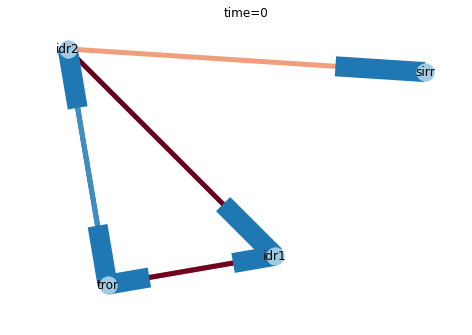

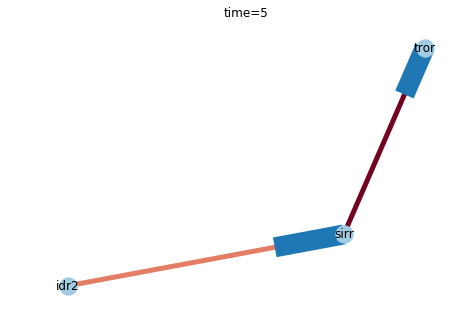

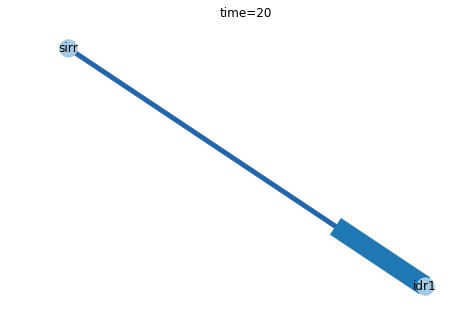

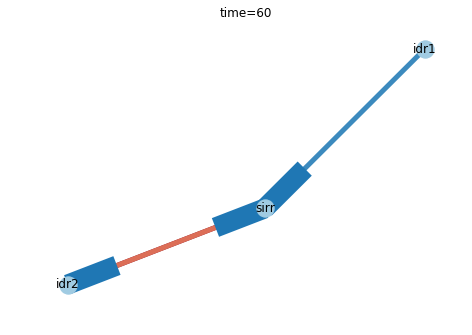

In [64]:
##Preliminary visulization of resultant network graphs at each time point.
##Cytoscape used in final paper Figure 5. 

for t in range(4):
    G=nx.DiGraph()

    colors = []
    for i, g in enumerate(['idr1', 'idr2', 'sirr', 'tror']):    
        for j, d in enumerate(['didr1', 'didr2', 'dsirr', 'dtror']):
            if i==j:
                continue

            if sig[t,i,j] < 5e-2:
                G.add_edge(d[1:],g,{"value":coeff[t,i,j]})
                colors.append(coeff[t,i,j])

    pos=nx.spring_layout(G)
    
    plt.figure()
    
    nx.draw(G,pos,node_color='#A0CBE2',edge_color=colors,width=5,
            edge_cmap=plt.cm.RdBu,with_labels=True,arrows=True,
            edge_vmin=-1,edge_vmax=1)
    plt.title('time=%d'%[0,5,20,60][t])
    